# Food Images Recognition Problem with Residual Network Algorithm

## Introduction to the Problem

The problem of this project is automatically recognizing pictured dishes, whic can be used for:

* users to effortlessly organize extensive photo collections 
* online photo repositories to make their content more accessible
* patients to estimate energy and nutrient intake in near real-time, outside of any constraining clinical environment

## Dataset Food-101

This real-world food dataset was created by downloading images from [foodspotting.com](foodspotting.com). The site allows users to take images of what they are eating, annotate place and type of food and upload these information online. The dataset was introduced in work "Food-101 – Mining Discriminative Components with Random Forests" ([link](https://www.vision.ee.ethz.ch/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)).

There are the top 101 most popular and consistently named dishes and randomly sampled 750 training images int he dataset. Additionally, 250 test images were collected for each class, and were manually cleaned. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. There are 101’000 realworld images in total, including very diverse but also visually and semantically similar food classes such as Apple pie, Waffles, Escargots, Sashimi, Onion rings, Mussels, Edamame, Paella, Risotto, Omelette, Bibimbap, Lobster bisque, Eggs benedict, Macarons to name a few. The dataset is available for download at [link](http://www.vision.ee.ethz.ch/datasets/food-101/).

## Residual Networks

To solve the problem of recognizing pictures better to use convolutional neural network. Using a deeper network have a huge barrier to train - vanishing gradients. Very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent unbearably slow. To solve the problem I will build very deep convolutional networks, using Residual Networks (ResNets), which will avoid vanishing gradients.

## Building a Residual Network

There are two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. I will implement both of them.

This project will be done in Keras. First step: load the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import compress
import warnings
import random
from keras import layers
from keras.layers import Input
from keras.layers import Add
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.models import Model

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import display 
from PIL import Image
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import LearningRateScheduler
from keras.initializers import glorot_uniform
from imageio import imread
from matplotlib.pyplot import imshow
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import gc

Using TensorFlow backend.


### The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation has the same dimension as the output activation. The upper path is the "shortcut path." The lower path is the "main path."

![](identity_block.png)
<p style="text-align: center;">Figure 1: Identity block. Skip connection "skips over" 3 layers.</p>

Here're the individual steps.

*First component of main path:*

* The first CONV2D has  F1F1  filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be conv_name_base + '2a'. Use 0 as the seed for the random initialization.
* The first BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2a'.
* Then apply the ReLU activation function. This has no name and no hyperparameters.

*Second component of main path:*

* The second CONV2D has  F2F2  filters of shape  (f,f)(f,f)  and a stride of (1,1). Its padding is "same" and its name should be conv_name_base + '2b'. Use 0 as the seed for the random initialization.
* The second BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2b'.
* Then apply the ReLU activation function. This has no name and no hyperparameters.

*Third component of main path:*

* The third CONV2D has  F3F3  filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be conv_name_base + '2c'. Use 0 as the seed for the random initialization.
* The third BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2c'. Note that there is no * ReLU activation function in this component.

*Final step:*

* The shortcut and the input are added together.
* Then apply the ReLU activation function. This has no name and no hyperparameters.

In [2]:
# identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 1
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. Need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

### The convolutional block

Next, the ResNet "convolutional block" is the other type of block. Use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:

![](convolutional_block.png)
<p style="text-align: center;">Figure 2: Convolutional block.</p>

The CONV2D layer in the shortcut path is used to resize the input  xx  to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.

The details of the convolutional block are as follows.

*First component of main path:*

* The first CONV2D has  F1F1  filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be conv_name_base + '2a'.
* The first BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2a'.
* Then apply the ReLU activation function. This has no name and no hyperparameters.

*Second component of main path:*

* The second CONV2D has  F2F2  filters of (f,f) and a stride of (1,1). Its padding is "same" and it's name should be conv_name_base + '2b'.
* The second BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2b'.
* Then apply the ReLU activation function. This has no name and no hyperparameters.

*Third component of main path:*

* The third CONV2D has  F3F3  filters of (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be conv_name_base + '2c'.
* The third BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2c'. Note that there is no * ReLU activation function in this component.

*Shortcut path:*

* The CONV2D has  F3F3  filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be conv_name_base + '1'.
* The BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '1'.

*Final step:*

* The shortcut and the main path values are added together.
* Then apply the ReLU activation function. This has no name and no hyperparameters.

In [3]:
# convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 2
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step:
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    return X

## Build ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

![](resnet50_model.png)
<p style="text-align: center;">Figure 3: ResNet-50 model.</p>

The details of this ResNet-50 model are:

* Zero-padding pads the input with a pad of (3,3)
* Stage 1:
    * The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
    * BatchNorm is applied to the channels axis of the input.
    * MaxPooling uses a (3,3) window and a (2,2) stride.
* Stage 2:
    * The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
    * The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
* Stage 3:
    * The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
    * The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
* Stage 4:
    * The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
    * The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
* Stage 5:
    * The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
    * The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
* The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
* The flatten doesn't have any hyperparameters or name.
* The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be 'fc' + str(classes).

In [4]:
# ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2, 2), name = 'avg_pool')(X)

    # output layer
    #X = Dropout(.4)(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)   
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

Run the following code to build the model's graph.

In [5]:
# Build model's graph

model = ResNet50(input_shape = (64, 64, 3), classes = 6)

Instructions for updating:
Colocations handled automatically by placer.


Configure the learning process by compiling the model.

In [6]:
# Compile the model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Load Dataset

The model is now ready to be trained. Let's load the Food-101 dataset. But first I would like to look at some images from dataset.

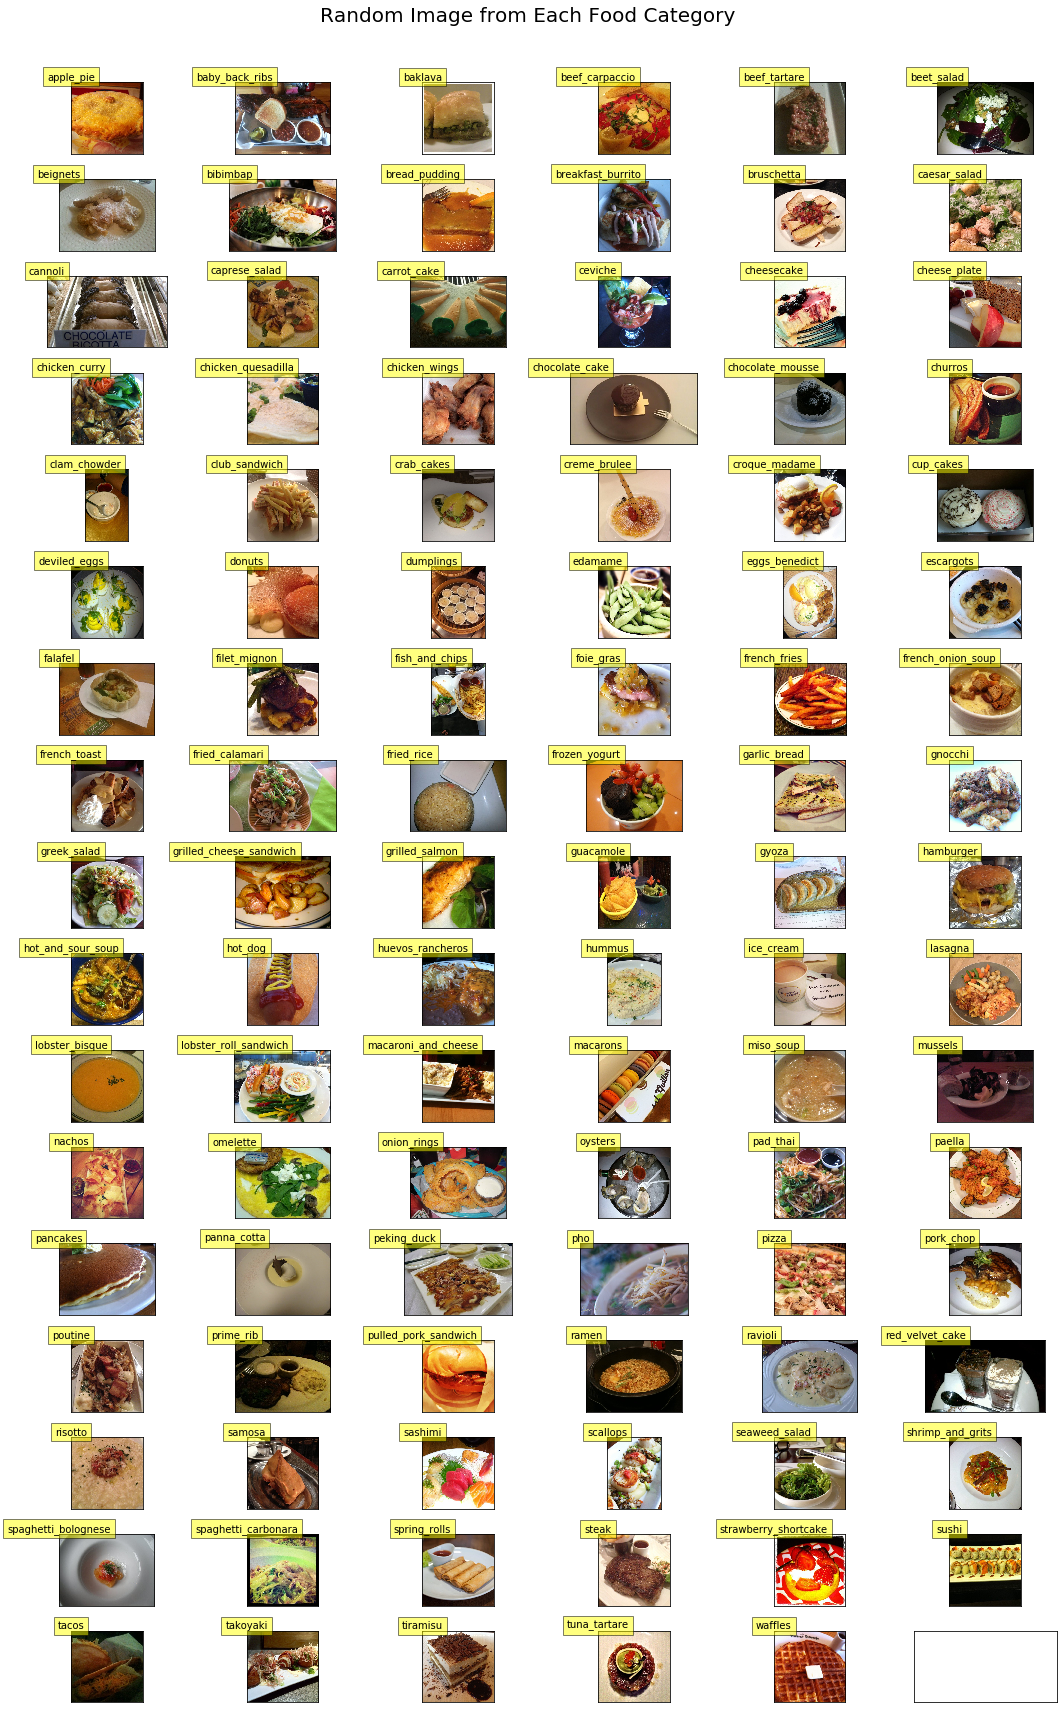

In [7]:
# Show random images from each category

# Get list of images
def show_random_imgs():
    with open('food-101/meta/train.txt', 'r') as txt:
        img_paths = [l.strip() for l in txt.readlines()]

    # Get list of Food Categories
        
    with open('food-101/meta/classes.txt', 'r') as txt:
        classes = [l.strip() for l in txt.readlines()]

    # Get list of images in each Food Category, select random one, appent to list of random_images    

    random_images = []   
    for f_class in classes:
        images_in_class = []
        for img in img_paths:
            if img.split("/")[0] == f_class:
                images_in_class.append(img)
        random_img = random.choice(images_in_class)
        rand_img_path = 'food-101/images/' + random_img + '.jpg'
        random_images.append(rand_img_path)

    # Vizualise images in grid

    warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

    rows = 17
    cols = 6
    fig, ax = plt.subplots(rows, cols, figsize=(15, 25))
    fig.suptitle('Random Image from Each Food Category', fontsize=20)

    for i in range(rows):
        for j in range(cols):
            try:
                img = imread(random_images[i*cols+j])
                ax[i][j].imshow(img)
                food_dir = random_images[i*cols+j].split("/")[2]
                ax[i][j].text(0, 0.5, food_dir, size=10, rotation=0,
                    ha="center", va="bottom", bbox=dict(facecolor='yellow', alpha=0.5))
            except:
                break
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
show_random_imgs()

In [8]:
# Load training/testing data

def load_dataset():
    """
    Function of loading data from food-101 dataset. Reads train.txt/test.txt file with list of paths 
    for training/testing images. Take each image, transfroms into array, expands and preprocesses.
    Gets all labels of images to train and then test the model.

    Returns:
    X_train -- dataset of features, expanded and preprocessed, for training the model
    Y_train -- labels of images transformed as one hot vectors for training the model
    X_test -- dataset of features, expanded and preprocessed, for the model
    Y_test -- labels of images transformed as one hot vectors for testing the model
    classes -- list of classes 
    fail_log -- log if any image preprocess fail
    """
     ### Load classes
    
    with open('food-101/meta/classes.txt', 'r') as txt:
        classes = [l.strip() for l in txt.readlines()]
        
    # Select only 6 food classes
    classes = classes[::20]
    num_classes = len(classes)
        
    ### Load train data: images and labels
    
    img_folder = '/Users/antont/projects/food-101/food-101/images/'
    fail_log = ''
    
    # Read paths of images for training data
    
    with open('food-101/meta/train.txt', 'r') as txt:
        train_paths = [l.strip() for l in txt.readlines()]
        
    # Select only 6 food classes
    
    train_paths = list(compress(train_paths, [l.split("/")[0] in classes for l in train_paths]))
    
    train_images = []
    train_labels = []
    
    # Trnasform each training image to array, expand, preprocess

    for line in train_paths:
        img_path = img_folder + line.strip() + '.jpg'
        label = line.split("/")[0]
        try:       
            img = image.load_img(img_path, target_size=(64, 64))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            train_images.append(x)
            train_labels.append(label)
        except:
            fail_log +='{}\n'.format(img_path)
            continue
    
    # Stack all arrays
    
    X_train = np.vstack(train_images)
    
    # Integer encode
    
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(train_labels)
    
    # One hot encode
    
    Y_train = to_categorical(integer_encoded, num_classes=num_classes)
    
    ### Load test data: images and labels
    
    # Read paths of images for testing data
    
    with open('food-101/meta/test.txt', 'r') as txt:
        test_paths = [l.strip() for l in txt.readlines()]
        
    # Select only 6 food classes
    
    test_paths = list(compress(test_paths, [l.split("/")[0] in classes for l in test_paths]))

    test_images = []
    test_labels = []

    # Trnasform each testing image to array, expand, preprocess
    
    for line in test_paths:
        img_path = img_folder + line.strip() + '.jpg'
        label = line.split("/")[0]
        try:       
            img = image.load_img(img_path, target_size=(64, 64))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            test_images.append(x)
            test_labels.append(label)
        except:
            fail_log +='{}\n'.format(img_path)
            continue
            
    # Stack all arrays
            
    X_test = np.vstack(test_images)
    
    # Integer encode
    
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(test_labels)
    
    # One hot encode
    
    Y_test = to_categorical(integer_encoded, num_classes=num_classes)
    
    # Normalize
    
    X_train = X_train/255.
    X_test = X_test/255.
    
    return X_train, Y_train, X_test, Y_test, classes, fail_log

In [9]:
%%time

# Load training/testing data

X_train, Y_train, X_test, Y_test, classes, fail_log = load_dataset()

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print ("classes shape: " + str(len(classes)))
fail_log

number of training examples = 4500
number of test examples = 1500
X_train shape: (4500, 64, 64, 3)
Y_train shape: (4500, 6)
X_test shape: (1500, 64, 64, 3)
Y_test shape: (1500, 6)
classes shape: 6
CPU times: user 21.8 s, sys: 1.79 s, total: 23.6 s
Wall time: 28.2 s


''

## Train and Test the Model

Run the following cell to train model. Use callback to control training.

In [10]:
# Callback to control training
import tensorflow as tf

class myCallback (tf.keras.callbacks.Callback):
    def on_epoch_end (self, epoch, logs={}):
        if (logs.get('loss') < .2):
            print("\nReached 80% accuracy!")
            self.model.stop_training = True

callbacks = myCallback()

I also used tried learning rate scheduler to decrese in epochs.

In [11]:
%%time

# Train the model

# datagen = ImageDataGenerator()

def schedule(epoch):
    lr = 1e-3
    if epoch >= 90:
        lr *= 0.5e-3
    elif epoch >= 60:
        lr *= 1e-2
    elif epoch >= 30:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
    
lr_scheduler = LearningRateScheduler(schedule)

# model.fit_generator(datagen.flow(X_train, Y_train, batch_size=64),
#                     steps_per_epoch=X_train.shape[0] / 64, epochs=32, use_multiprocessing=True,
#                     callbacks = [lr_scheduler, callbacks])

model.fit(X_train, Y_train, epochs=120, batch_size=64, callbacks = [lr_scheduler, callbacks])

Instructions for updating:
Use tf.cast instead.
Epoch 1/120
Learning rate:  0.001
4500/4500 [==============================] - 282s 63ms/step - loss: 2.2337 - acc: 0.2651
Epoch 2/120
Learning rate:  0.001
4500/4500 [==============================] - 242s 54ms/step - loss: 1.7963 - acc: 0.3631
Epoch 3/120
Learning rate:  0.001
4500/4500 [==============================] - 241s 54ms/step - loss: 1.8286 - acc: 0.3327
Epoch 4/120
Learning rate:  0.001
4500/4500 [==============================] - 241s 54ms/step - loss: 1.6044 - acc: 0.3871
Epoch 5/120
Learning rate:  0.001
4500/4500 [==============================] - 241s 53ms/step - loss: 1.5683 - acc: 0.4298
Epoch 6/120
Learning rate:  0.001
4500/4500 [==============================] - 241s 54ms/step - loss: 1.4571 - acc: 0.4722
Epoch 7/120
Learning rate:  0.001
4500/4500 [==============================] - 241s 54ms/step - loss: 1.6120 - acc: 0.4202
Epoch 8/120
Learning rate:  0.001
4500/4500 [==============================] - 241s 54ms/st

4500/4500 [==============================] - 241s 54ms/step - loss: 1.1578 - acc: 0.5647
Epoch 65/120
Learning rate:  1e-05
4500/4500 [==============================] - 241s 54ms/step - loss: 1.1255 - acc: 0.5747
Epoch 66/120
Learning rate:  1e-05
4500/4500 [==============================] - 241s 54ms/step - loss: 1.1354 - acc: 0.5733
Epoch 67/120
Learning rate:  1e-05
4500/4500 [==============================] - 241s 53ms/step - loss: 1.1213 - acc: 0.5684
Epoch 68/120
Learning rate:  1e-05
4500/4500 [==============================] - 241s 54ms/step - loss: 1.1154 - acc: 0.5822
Epoch 69/120
Learning rate:  1e-05
4500/4500 [==============================] - 241s 54ms/step - loss: 1.1277 - acc: 0.5798
Epoch 70/120
Learning rate:  1e-05
4500/4500 [==============================] - 241s 54ms/step - loss: 1.1234 - acc: 0.5798
Epoch 71/120
Learning rate:  1e-05
4500/4500 [==============================] - 241s 54ms/step - loss: 1.0972 - acc: 0.5791
Epoch 72/120
Learning rate:  1e-05
4500/450

Let's see how this model performs on the test set.

In [12]:
%%time

# Evaluate model performance

# preds = model.evaluate_generator(datagen.flow(X_test, Y_test, batch_size=64), 
#                                  steps = X_test.shape[0] / 64, use_multiprocessing=True)
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = "+ str(preds[1]))

1500/1500 [==============================] - 29s 19ms/step
Loss = 1.9851422080993653
Test Accuracy = 0.3660000001192093
CPU times: user 47.9 s, sys: 1.36 s, total: 49.2 s
Wall time: 28.7 s


Need to proceed more training, it looks like 120 epochs not enough to train deeper model, like ResNet50.

## Test on my own image

Input image shape: (1, 64, 64, 3)
food class predicted:  french_fries


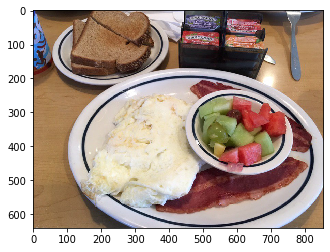

In [13]:
img_path = 'my_food_1.jpeg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)
prediction = model.predict(x)
print("food class predicted: ", classes[np.argmax(prediction)])

Input image shape: (1, 64, 64, 3)
food class predicted:  french_fries


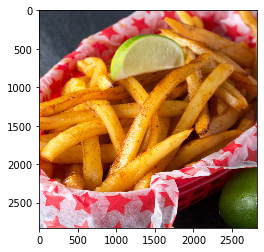

In [14]:
img_path = 'my_food_2.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)
prediction = model.predict(x)
print("food class predicted: ", classes[np.argmax(prediction)])

Summary of the model:

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation